# Анализ популярного сервиса аренды самокатов GoFast

Для анализа переданы данные о некоторых пользователях популярного сервиса аренды самокатов GoFast из нескольких городов, а также об их поездках. Требуется проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
* без подписки
  * абонентская плата отсутствует;
  * стоимость одной минуты поездки — 8 рублей;
  * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
  * абонентская плата — 199 рублей в месяц;
  * стоимость одной минуты поездки — 6 рублей;
  * стоимость старта — бесплатно.

## Описание данных

**Пользователи — `users_go.csv`**

- `user_id`	— уникальный идентификатор пользователя
- `name` — имя пользователя
- `age` —	возраст
- `city` — город
- `subscription_type` — тип подписки (free, ultra)

**Поeздки — `rides_go.csv`**

- `user_id`	— уникальный идентификатор пользователя
- `distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date` — дата совершения поездки

**Подписки — `subscriptions_go.csv`**

- `subscription_type` — тип подписки
- `minute_price` — стоимость одной минуты поездки по данной подписке
- `start_ride_price` — стоимость начала поездки
- `subscription_fee` — стоимость ежемесячного платежа

In [1]:
# импортируем необходимые для работы библиотеки 

import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

%matplotlib inline

#### Шаг 1. Загрузка данных

In [2]:
# cчитаtv CSV-файлы с данными с помощью библиотеки pandas и сохраним их в датафреймы
users = pd.read_csv('datasets/users_go.csv')
rides = pd.read_csv('datasets/rides_go.csv')
subscriptions = pd.read_csv('datasets/subscriptions_go.csv')

**Датафрейм "Пользователи" (`users`)**

In [3]:
# содержимое датафрейма
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
# размерность датафрейма
users.shape

(1565, 5)

In [5]:
# посмотрим общую информацию о датафрейме
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [6]:
# посмотрим статистику датафрейма (только для числовых параметров)
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


**Вывод о данных по датафрейму "Пользователи" (`users`)**

Таблица `users` состоит из 1565 строк и 5 столбцов, в данных нет пропусков, данные представлены строковыми значениями (`name`, `city`, `subscription_type`) и целочисленными значениями (`user_id`, `age`).

Средний возраст пользователей: от 20 до 30 лет.

**Датафрейм "Поездки" (`rides`)**

In [7]:
# содержимое датафрейма
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [8]:
# размерность датафрейма
rides.shape

(18068, 4)

In [9]:
# посмотрим общую информацию о датафрейме
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [10]:
# посмотрим статистику датафрейма (только для числовых параметров)
rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


**Вывод о данных по датафрейму "Поездки" (`rides`)**

Таблица `rides` состоит из 18068 строк и 4 столбцов, в данных нет пропусков, данные представлены строковыми значениями (`date`), целочисленными значениями (`user_id`) и вещественными значениями (`distance`, `duration`).

Средняя длительность поездок составляет `17` минут, среднее расстояние поездок составляет `3` км.

**Датафрейм "Подписки" (`subscriptions`)**

In [11]:
# содержимое датафрейма
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [12]:
# размерность датафрейма
subscriptions.shape

(2, 4)

In [13]:
# посмотрим общую информацию о датафрейме
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод о данных по датафрейму "Подписки" (`subscriptions`)**

Небольшой датафрейм, состоящий всего из 2 строк и 4 столбцов, пропусков в данных нет, данные представленны строковыми значениями (`subscription_type`) и целочисленными значениями (`minute_price`, `start_ride_price`, `subscription_fee`).

Доступны 2 варианта подписки с разной оплатой по тарифу.

#### Шаг 2. Предобработка данных

В таблице "Поездки" есть данные, которые стоит изменить. Приведем столбец `date` в таблице `rides` к типу даты pandas.

In [14]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['date'].head(10)

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
5   2021-10-09
6   2021-10-19
7   2021-11-06
8   2021-11-14
9   2021-11-22
Name: date, dtype: datetime64[ns]

Теперь создадим новый столбец с номером месяца на основе полученного столбца `date`. Но сначала, стоит проверить, за какой период предоставлены данные, т. к., если данные представлены за несколько лет, данные по одинаковым месяцам разных лет могут попасть в один месяц.

In [15]:
rides['date'].dt.year.unique()

array([2021], dtype=int64)

Данные представлены только за 2021 год, поэтому накладок не будет.

Добавим в таблицу столбец с номером месяца.

In [16]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


В данном случае нам повезло: полученные в таблицах данные (как было проверено выше) не содержат пропусков, значит, их не придется заполнять.

Проверим наличие дубликатов в датафреймах.

In [17]:
# таблица users
users.duplicated().sum()

31

In [18]:
# дубликаты присутствуют, избавимся от них и проверим результат
users.drop_duplicates(inplace=True)
users.duplicated().sum()

0

In [19]:
# таблица rides, дубликатов нет
rides.duplicated().sum()

0

**Вывод по предобработке**

Пропусков в данных в предоставленных таблицах нет. Дубликаты были в таблице пользователей, они были успешно удалены. Для дальнейшей работы в таблицу `rides` был добавлен столбец `month` с номер месяца.

#### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках.

Посмотрим **частоту встречаемости городов**.

In [20]:
cities_of_users = users['city'].value_counts()
cities_of_users

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

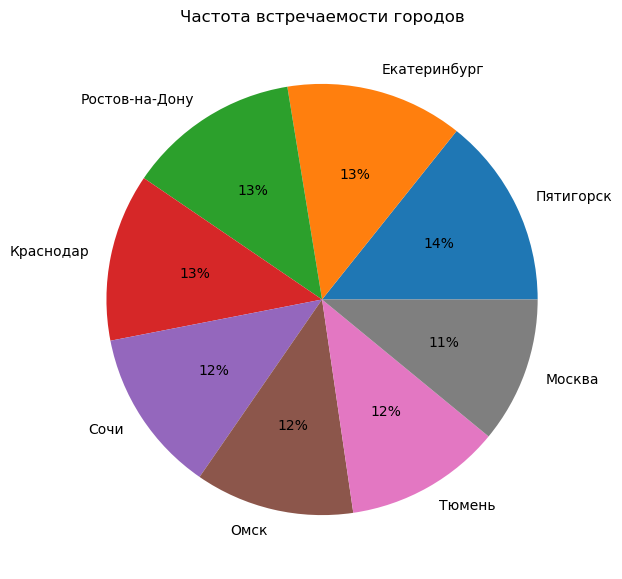

In [21]:
# для наглядности посмотрим круговую диаграмму
cities_of_users.plot(
    kind='pie',
    autopct='%1.0f%%',
    figsize=(7, 7),
    title='Частота встречаемости городов'
)

plt.ylabel('')
plt.show()

**Вывод**: города в предоставленных данных представлено в примерно равном соотношении, однако Пятигорск можно вылелить как город, в котором проживает бОльшее количество пользователей сервиса, а Москву - как город с меньшим количеством пользователей данного сервиса.

Посмотрим **соотношение пользователей с подпиской и без подписки**.

In [22]:
users_by_subscription = users['subscription_type'].value_counts()
users_by_subscription

free     835
ultra    699
Name: subscription_type, dtype: int64

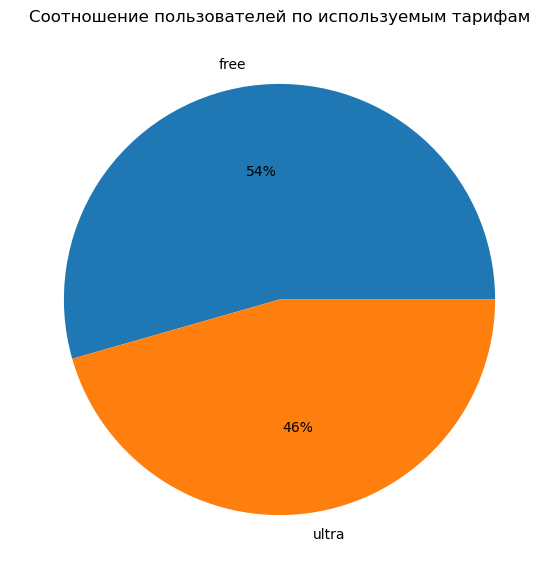

In [23]:
# также построим круговую диаграмму
users_by_subscription.plot(
    kind='pie',
    autopct='%1.0f%%',
    figsize=(7, 7),
    title='Соотношение пользователей по используемым тарифам'
)

plt.ylabel('')
plt.show()

**Вывод**: преобладают пользователи с бесплатным тарифом, их 54 % или 835 человек.

Посмотрим **возраст пользователей**.

In [24]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

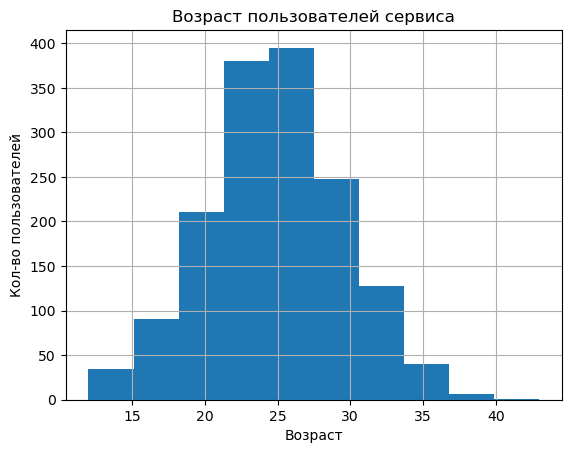

In [25]:
plt.hist(users['age'], bins=10)
plt.title('Возраст пользователей сервиса')
plt.xlabel('Возраст')
plt.ylabel('Кол-во пользователей')
plt.grid()
plt.show()

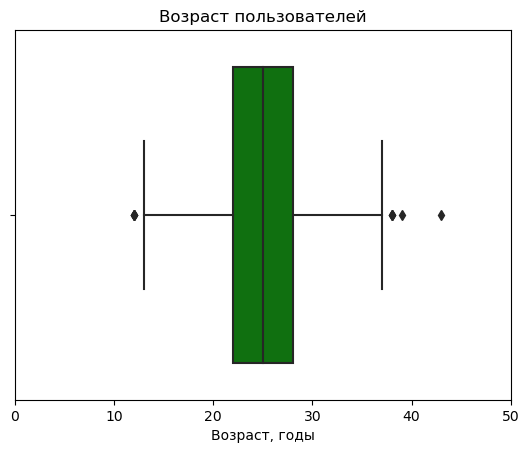

In [26]:
sns.boxplot(x=users['age'], color='green')
plt.title('Возраст пользователей')
plt.xlabel('Возраст, годы')
plt.xlim(0, 50);

**Вывод**: основная масса пользователей представлена людьми в возрасте между 20 и 30 годами. Самый младший пользователь - 12-летний ребенок, самому старшему пользователю 43 года.

Посмотрим **расстояние, которое пользователь преодолел за одну поездку**.

In [27]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

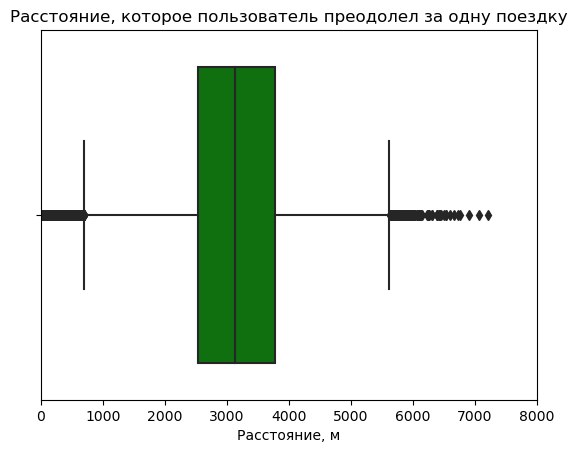

In [28]:
sns.boxplot(x=rides['distance'], color='green')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, м')
plt.xlim(0, 8000);

**Вывод**: в среднем за одну поездку пользователи проезжают чуть больше `3` км, `50 %` поездок характеризуются растоянием от `2.5` км до `3.8` км. Минимальное расстояние составляет всего несколько метров (менее `100` м), а максимальное расстояние, которое проезжают пользователи составляет `7.2` км.

Посмотрим **продолжительность поездок**.

In [29]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

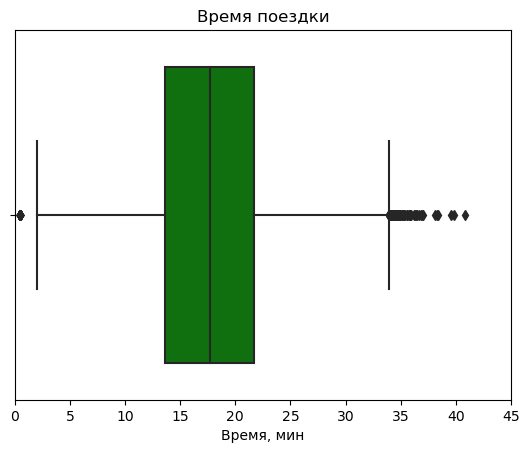

In [30]:
sns.boxplot(x=rides['duration'], color='green')
plt.title('Время поездки')
plt.xlabel('Время, мин')
plt.xlim(0, 45);

**Вывод**: в среднем поездки составляют около `17` мин, `50 %` поездок характеризуются длительностью от `14` мин до `22` мин. Минимальная длительность поездок составляет всего полминуты, а максимальная - чуть больше `40` мин.

#### Шаг 4. Объединение данных

In [31]:
# объединяем датафреймы users и rides по столбцу 'user_id'
data = users.merge(rides, on='user_id', how='inner')

# объединяем полученный датафрейм с датафреймом subscriptions по столбцу 'subscription_type'
data = data.merge(subscriptions, on='subscription_type', how='inner')

In [32]:
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [33]:
# проверим количество пропусков
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Создадим отдельный датафрейм с пользователями **без подписки**.

In [34]:
free_subscription = data.query("subscription_type == 'free'")

In [35]:
free_subscription

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Создадим отдельный датафрейм с пользователями **с подпиской**.

In [36]:
ultra_subscription = data.query("subscription_type == 'ultra'")

In [37]:
ultra_subscription

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

Сначала сравним **время поездок** пользователей с подпиской и без нее.

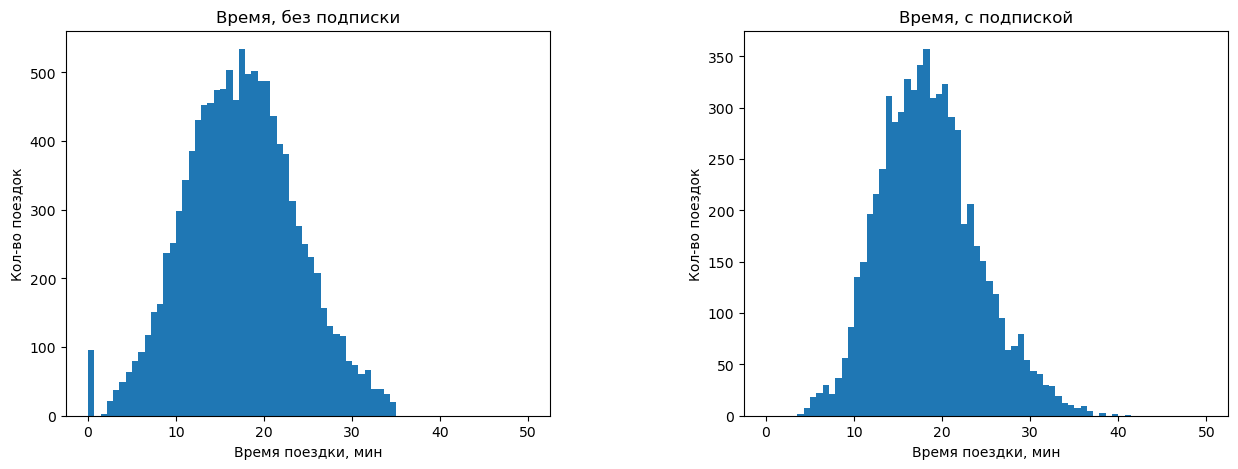

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# первый график для поездок без подписки
ax1.hist(free_subscription['duration'], bins=70, range=(0, 50))
ax1.set_title('Время, без подписки')
ax1.set_xlabel('Время поездки, мин')
ax1.set_ylabel('Кол-во поездок')

# второй график для поездок с подпиской
ax2.hist(ultra_subscription['duration'], bins=70, range=(0, 50))
ax2.set_title('Время, с подпиской')
ax2.set_xlabel('Время поездки, мин')
ax2.set_ylabel('Кол-во поездок')

# располагаем графики рядом для удобства
plt.subplots_adjust(wspace=0.4)

plt.show()

Теперь сравним **расстояния поездок** пользователей с подпиской и без нее.

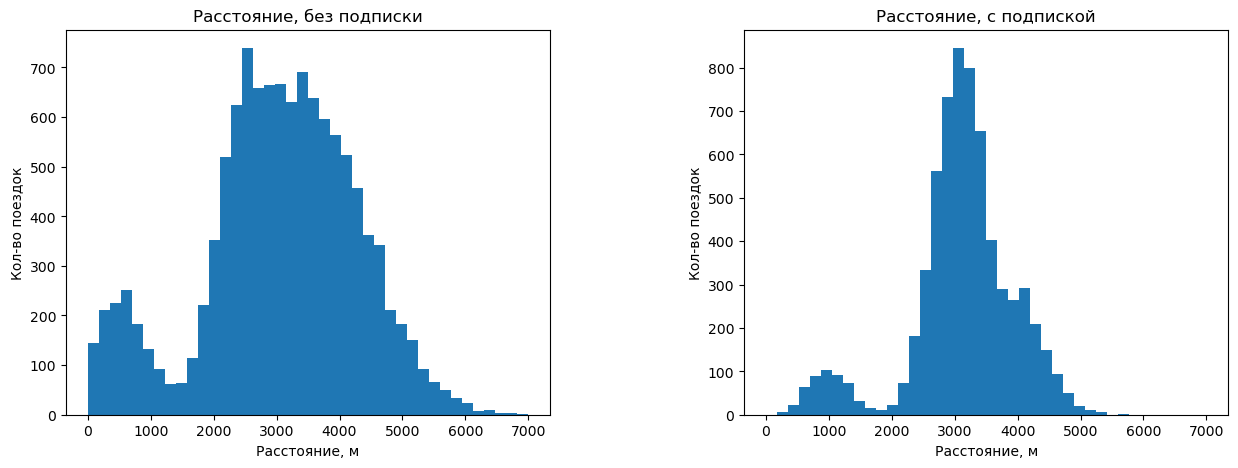

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# первый график для поездок без подписки
ax1.hist(free_subscription['distance'], bins=40, range=(0, 7000))
ax1.set_title('Расстояние, без подписки')
ax1.set_xlabel('Расстояние, м')
ax1.set_ylabel('Кол-во поездок')

# второй график для поездок с подпиской
ax2.hist(ultra_subscription['distance'], bins=40, range=(0, 7000))
ax2.set_title('Расстояние, с подпиской')
ax2.set_xlabel('Расстояние, м')
ax2.set_ylabel('Кол-во поездок')

# располагаем графики рядом для удобства
plt.subplots_adjust(wspace=0.4)

plt.show()

**Вывод**:

Для удобства работы мы объединили данные о пользователях, поездках и подписках в один датафрейм`data`.

Используя полученный датафрейм, создали два отдельных датафрейма:
- `free_subscription` - информация о пользователях без подписки
- `ultra_subscription` - информация о пользователях с подпиской

Пользователей **без подписки** оказалось чуть ли не в 2 раза больше (`11568` человек), чем пользователей **с подпиской** (`6500` человек).

Информация о расстоянии и времени поездок пользователей без подписки и с подпиской была визуализирована, на основе чего можно сделать следующие выводы:

Время поездки пользователей обеих категорий составляет в среднем от `10` до `25` минут, однако пользователи **без подписки** используют самокаты и для очень коротких поездок, буквально на минутку, чего не делают пользователи с подпиской, они совершают более длительные поездки.

Расстояние пользователи **без подписки** покрывают намного больше, до `7` км, в то время как пользователи **с подпиской** проезжают чуть более `5` км.

Таким образом, можно сделать вывод, что длительность поездок не особенно зависит от наличия подписки, а вот расстояние пользователи **без подписки** проезжают бОльшее.

#### Шаг 5. Подсчёт выручки

Найдем суммарное расстояние, количество поeздок и суммарное время для каждого пользователя за каждый месяц.

In [40]:
total_data = pd.pivot_table(
    data,
    index=['user_id', 'month'],
    values=['distance', 'name', 'duration', 'subscription_type'],
    aggfunc={'distance': 'sum', 'name': 'count', 'duration': 'sum', 'subscription_type': min}
)

In [41]:
total_data.rename(columns={'name': 'count'}, inplace=True)

In [42]:
total_data

distance   duration  count subscription_type
user_id month                                                  
1       1       7027.511294  41.416640      2             ultra
        4        754.159807   6.232113      1             ultra
        8       6723.470560  44.776802      2             ultra
        10      5809.911100  31.578017      2             ultra
        11      7003.499363  53.397424      3             ultra
...                     ...        ...    ...               ...
1534    6       3409.468534  24.812678      2              free
        8       7622.453034  47.205960      2              free
        9       4928.173852  22.560373      1              free
        11     13350.015305  76.342174      4              free
        12      2371.711192  15.893917      1              free

[11331 rows x 4 columns]

In [43]:
# округлим значения столбца 'duration' в таблице до ближайшего целого числа вверх
total_data['duration'] = np.ceil(total_data['duration'])

In [44]:
# проверим, что получилось
total_data.query('user_id == 1')

distance  duration  count subscription_type
user_id month                                                
1       1      7027.511294      42.0      2             ultra
        4       754.159807       7.0      1             ultra
        8      6723.470560      45.0      2             ultra
        10     5809.911100      32.0      2             ultra
        11     7003.499363      54.0      3             ultra
        12     6751.629942      28.0      2             ultra

Добавим **столбец с помесячной выручкой**, которую принёс каждый пользователь.

In [45]:
# напишем функцию для подсчета помесячной выручки
# цена старта * кол-во поездок + цена одной мин * общ. длит. всех поездок в мин + цена подписки

one_min_ultra = 6
one_min_free = 8

start_ultra = 0
start_free = 50

abon_ultra = 199
abon_free = 0

def month_revenue(row):
    if row['subscription_type'] == 'ultra':
        return start_ultra * row['count'] + one_min_ultra * row['duration'] + abon_ultra
    elif row['subscription_type'] == 'free':
        return start_free * row['count'] + one_min_free * row['duration'] + abon_free
    else:
        return 'N/A'

In [46]:
# добавим столбец
total_data['revenue_per_month'] = total_data.apply(month_revenue, axis=1)

In [47]:
# проверим результат
total_data.head()

distance  duration  count subscription_type  \
user_id month                                                   
1       1      7027.511294      42.0      2             ultra   
        4       754.159807       7.0      1             ultra   
        8      6723.470560      45.0      2             ultra   
        10     5809.911100      32.0      2             ultra   
        11     7003.499363      54.0      3             ultra   

               revenue_per_month  
user_id month                     
1       1                  451.0  
        4                  241.0  
        8                  469.0  
        10                 391.0  
        11                 523.0

In [48]:
total_data.query('user_id == 1')

distance  duration  count subscription_type  \
user_id month                                                   
1       1      7027.511294      42.0      2             ultra   
        4       754.159807       7.0      1             ultra   
        8      6723.470560      45.0      2             ultra   
        10     5809.911100      32.0      2             ultra   
        11     7003.499363      54.0      3             ultra   
        12     6751.629942      28.0      2             ultra   

               revenue_per_month  
user_id month                     
1       1                  451.0  
        4                  241.0  
        8                  469.0  
        10                 391.0  
        11                 523.0  
        12                 367.0

**Вывод:**

Для удобства работы был создан новый датафрейм с агрегированными данными `total_data` на основе датафрейма с объединенными данными `data`.

В результате была получена таблица, содержащая суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, а также добавлен столбец с помесячной выручкой, которую принес каждый пользователь.

#### Шаг 6. Проверка гипотез

**1.** Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Проверим гипотезу: **пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.**

H_0: время поездок (`duration`) пользователей с подпиской `ultra` **равно** времени поездок (`duration`) пользователей без подписки (`free`)

H_1: время поездок (`duration`) пользователей с подпиской `ultra` **больше** времени поездок (`duration`) пользователей без подписки (`free`)

Уровень статистической значимости установим 5 % (`alpha = 0.05`).

In [49]:
ultra = ultra_subscription['duration'] 

free = free_subscription['duration']

results = st.ttest_ind(
    ultra,
    free,
    alternative='greater'
)

alpha = 0.05

print('P-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

P-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


**Вывод:** проверили и отвергли гипотезу о том, что время поездки пользователей с подпиской `ultra` равно времени поездки пользователей без подписки (`free`).

**2.** Расстояние одной поездки в `3130` метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает `3130` метров? Проверим гипотезу и сделаем выводы.

Проверим гипотезу: **пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.**

H_0: расстояние поездок (`distance`) пользователей с подпиской `ultra` **равно** `3130` метров

H_1: расстояние поездок (`distance`) пользователей с подпиской `ultra` **меньше** ("не превышает") `3130` метров

Уровень статистической значимости установим 5 % (`alpha = 0.05`).

In [50]:
ultra_dist = ultra_subscription['distance']

interested_value = 3130.0

alpha = 0.05

results = st.ttest_1samp(
    ultra_dist, 
    interested_value,
    alternative='less')
    
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

P-value: 0.08046311521502146
Не удалось отвергнуть нулевую гипотезу


**Вывод:** проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи с подпиской `ultra` не превышает `3130` метров.

**3.** Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Проверим гипотезу: **помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки**

H_0: выручка (`revenue_per_month`) от пользователей с подпиской `ultra` **равна** выручке (`revenue_per_month`) от пользователей без подписки (`free`)

H_1: выручка (`revenue_per_month`) от пользователей на подписке `ultra` **больше** ("выше"), чем выручка (`revenue_per_month`) от пользователей без подписки (`free`)

Уровень статистической значимости установим 5 % (`alpha = 0.05`).

In [51]:
ultra_per_month = total_data.loc[total_data.subscription_type == 'ultra', 'revenue_per_month'] 

free_per_month = total_data.loc[total_data.subscription_type == 'free', 'revenue_per_month'] 


results = st.ttest_ind(
    ultra_per_month,
    free_per_month,
    alternative='greater'
)

alpha = 0.05

print('P-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

P-value: 2.8130926188487286e-35
Отвергаем нулевую гипотезу


**Вывод:** проверили и отвергли гипотезу о том, что выручка от пользователей с подпиской `ultra` превышает выручку от пользователей без подписки (`free`).

**4.** Представим такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест понадобился бы для проверки этой гипотезы?

**Ответ:**
    
В данном случае следует использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Гипотезы будут следующие:

- H_0: μ1 = μ2
- H_1: μ1 != μ2

где μ1 и μ2 - это средние значения количества обращений в техподдержку до и после обновления серверов.

Метод, который нужно использовать для сравнения: `scipy.stats.ttest_rel()`

#### Шаг 7. Выводы

Для работы нам были предоставлены данные о некоторых пользователях из нескольких городов, а также об их поездкахю Было загружено три датафрейма: с данными о пользователях, с информацией о поездках и с информацией о подписках. 

Данные были проверены на пропуски (пропусков не было ни в одной из предоставленных таблиц) и на наличие дубликатов (были удалены дубликаты строк из датафрейма с данными о пользователях). Также для удобства и дальнейшей работы тип данных столбца `date` в датафрейме `rides` был приведен к типу даты pandas. Далее в датафрейм был добавлен столбец `month` с номером месяца.

Далее данные из трех датафреймов были объединены в один общий датафрейм (`data`).

После завершения подготовки данных был проведен исследовательский анализ, по результатам которого были сделаны следующие выводы:

- количество пользователей по городам распределено примерно одинаково, но лидером по количеству пользователей можно считать Пятигорск - в нем `219` пользователей, а меньше всего пользователей в Москве - всего `168` человек;
- пользователей без подписки больше - `835` человек, что составляет `~54` % от общего количества пользователей, подпиской пользуются 699 пользователей, что соответственно составляет `~46` %;
- возраст большинства пользователей составляет от `20` до `30` лет, но есть среди пользователей дети, и люди старше `40` лет;
- пользователи без подписки проезжают более длинные расстояния, при этом чаще, чем пользователи с подпиской, берут самокаты на очень небольшой срок;
- чаще всего длительность поездок всех пользователей состовляет от `10` до `25` минут.

Далее мы объединили данные о пользователях, поездках и подписках в один датафрейм, на его основе создали еще два датафрейма:
- для пользователей с подспиской `ultra`;
- для пользователей без подписки (`free`).

Далее мы нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц и вывели все данные в отдельный датафрейм `total_data`.
Добавили в датафрейм `total_data` столбец с помесячной выручкой `revenue_per_month`.

Были проверены следующие гипотезы:

- Пользователи с подпиской `ultra` тратят больше времени на поездки, чем пользователи без подписки
    - Отвергли нулевую гипотезу
- Пользователи с подпиской `ultra` проезжают расстояние, не превышающее `3130` метров за одну поездку
    - Не удалось отвергнуть нулевую гипотезу
- Помесячная выручка от пользователей с подпиской `ultra` выше, чем выручка от пользователей без подписки
    - Отвергли нулевую гипотезу